## Exploratory Analysis of Stack Encoder Ensemble with Extreme Gradient Boosting

In [ ]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import model
import time
from datetime import datetime
from datetime import timedelta
sns.set()

## 01 - Set the path and load the datset

In [14]:
# Define files path

DATA_PATH = '../data/'

In [15]:
df = pd.read_csv(DATA_PATH + 'GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


## 02 - Normalize the scales

In [16]:
minmax = MinMaxScaler().fit(df.iloc[:, 3].values.reshape((-1,1)))
close_normalize = minmax.transform(df.iloc[:, 3].values.reshape((-1,1))).reshape((-1))

In [7]:
close_normalize.shape

(252,)

## 03 - Define the model (encoder-decoder configurarion)

In [17]:
class encoder:
    def __init__(self, input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20):
        input_size = input_.shape[1]
        self.X = tf.placeholder("float", [None, input_.shape[1]])
    
        weights = {
        'encoder_h1': tf.Variable(tf.random_normal([input_size, hidden_layer])),
        'encoder_h2': tf.Variable(tf.random_normal([hidden_layer, dimension])),
        'decoder_h1': tf.Variable(tf.random_normal([dimension, hidden_layer])),
        'decoder_h2': tf.Variable(tf.random_normal([hidden_layer, input_size])),
        }
    
        biases = {
        'encoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'encoder_b2': tf.Variable(tf.random_normal([dimension])),
        'decoder_b1': tf.Variable(tf.random_normal([hidden_layer])),
        'decoder_b2': tf.Variable(tf.random_normal([input_size])),
        }
    
        first_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(self.X, weights['encoder_h1']), biases['encoder_b1']))
        self.second_layer_encoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_encoder, weights['encoder_h2']), biases['encoder_b2']))
        first_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(self.second_layer_encoder, weights['decoder_h1']), biases['decoder_b1']))
        second_layer_decoder = tf.nn.sigmoid(tf.add(tf.matmul(first_layer_decoder, weights['decoder_h2']), biases['decoder_b2']))
        self.cost = tf.reduce_mean(tf.pow(self.X - second_layer_decoder, 2))
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
        for i in range(epoch):
            last_time = time.time()
            _, loss = self.sess.run([self.optimizer, self.cost], feed_dict={self.X: input_})
            if (i + 1) % 10 == 0:
                print('epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time)
    
    def encode(self, input_):
        return self.sess.run(self.second_layer_encoder, feed_dict={self.X: input_})

## 05 - Instaciate the model and train

In [18]:
tf.reset_default_graph()
Encoder=encoder(close_normalize.reshape((-1,1)), 32, 0.01, 128, 100)
thought_vector = Encoder.encode(close_normalize.reshape((-1,1)))
thought_vector.shape

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10 loss: 0.057660542 time: 0.0006899833679199219
epoch: 20 loss: 0.041162197 time: 0.0006682872772216797
epoch: 30 loss: 0.031039406 time: 0.0015881061553955078
epoch: 40 loss: 0.019814234 time: 0.0007331371307373047
epoch: 50 loss: 0.010612289 time: 0.0007879734039306641
epoch: 60 loss: 0.005019552 time: 0.0007429122924804688
epoch: 70 loss: 0.19365424 time: 0.0006840229034423828
epoch: 80 loss: 0.051250715 time: 0.001039743423461914
epoch: 90 loss: 0.04515558 time: 0.0007808208465576172
epoch: 100 loss: 0.040901925 time: 0.001589059829711914


(252, 32)

## 06 - Setup several other models not used for comparison purposes

In [19]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500)

## 07 - Fit the training data to the corrersponding models

In [20]:
ada.fit(thought_vector[:-1, :], close_normalize[1:])
bagging.fit(thought_vector[:-1, :], close_normalize[1:])
et.fit(thought_vector[:-1, :], close_normalize[1:])
gb.fit(thought_vector[:-1, :], close_normalize[1:])
rf.fit(thought_vector[:-1, :], close_normalize[1:])

RandomForestRegressor(n_estimators=500)

## 08 - Plot some lags feature importance for each of the models

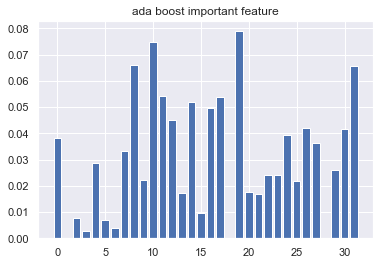

In [21]:
plt.bar(np.arange(32), ada.feature_importances_)
plt.title('ada boost important feature')
plt.show()

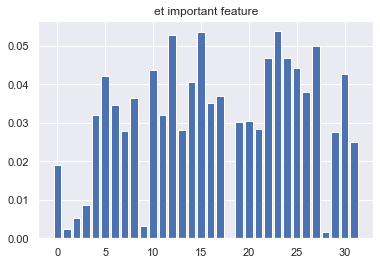

In [22]:
plt.bar(np.arange(32), et.feature_importances_)
plt.title('et important feature')
plt.show()

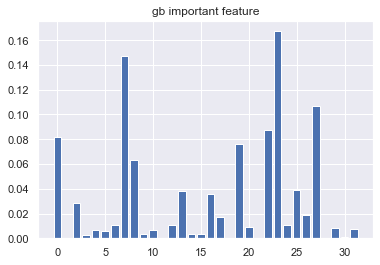

In [23]:
plt.bar(np.arange(32), gb.feature_importances_)
plt.title('gb important feature')
plt.show()

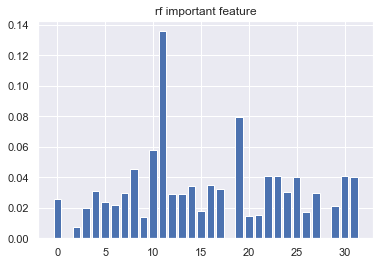

In [24]:
plt.bar(np.arange(32), rf.feature_importances_)
plt.title('rf important feature')
plt.show()

## 09 - Make some predictions on those models

In [25]:
ada_pred=ada.predict(thought_vector)
bagging_pred=bagging.predict(thought_vector)
et_pred=et.predict(thought_vector)
gb_pred=gb.predict(thought_vector)
rf_pred=rf.predict(thought_vector)

## 10 - Cretae the stacked verison with all precitions for all models

In [26]:
ada_actual = np.hstack([close_normalize[0],ada_pred[:-1]])
bagging_actual = np.hstack([close_normalize[0],bagging_pred[:-1]])
et_actual = np.hstack([close_normalize[0],et_pred[:-1]])
gb_actual = np.hstack([close_normalize[0],gb_pred[:-1]])
rf_actual = np.hstack([close_normalize[0],rf_pred[:-1]])
stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,close_normalize]).T
corr_df = pd.DataFrame(stack_predict)

## 11 - Show the correlation among those models

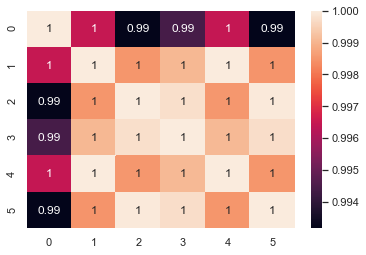

In [27]:
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

### NOTE: Almost all the same importance, lots of correlation among the models

## 12 - Train a Extreme Gradient Boosting models 

In [31]:
import xgboost as xgb
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = close_normalize[1:]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict[:-1,:],train_Y, eval_set=[(stack_predict[:-1,:],train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=8, num_parallel_tree=1,
             objective='reg:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## 13 - And make some predictions

In [32]:
xgb_pred = clf.predict(stack_predict)
xgb_actual = np.hstack([close_normalize[0],xgb_pred[:-1]])
date_original=pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()

## 14 - Make inverse transformation to bring scales to origin and plots the models fit

In [33]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

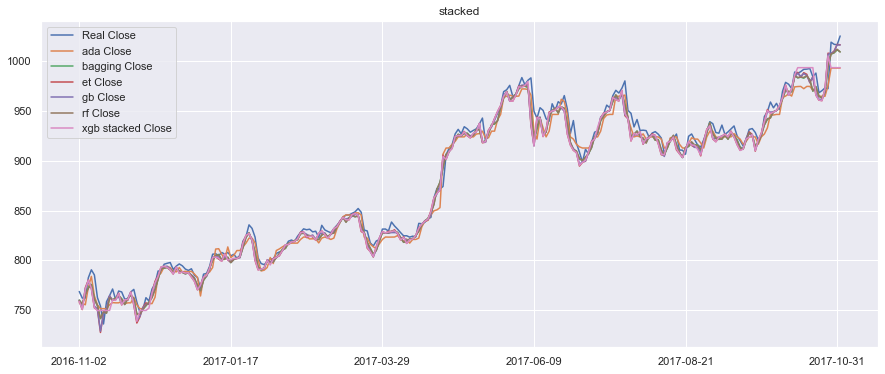

In [34]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range, reverse_close(ada_pred), label = 'ada Close')
plt.plot(x_range, reverse_close(bagging_pred), label = 'bagging Close')
plt.plot(x_range, reverse_close(et_pred), label = 'et Close')
plt.plot(x_range, reverse_close(gb_pred), label = 'gb Close')
plt.plot(x_range, reverse_close(rf_pred), label = 'rf Close')
plt.plot(x_range, reverse_close(xgb_pred), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range[::50], date_original[::50])
plt.title('stacked')
plt.show()

## 15 - Lest make some predictions on those models (30 day period)

In [35]:
ada_list = ada_pred.tolist()
bagging_list = bagging_pred.tolist()
et_list = et_pred.tolist()
gb_list = gb_pred.tolist()
rf_list = rf_pred.tolist()
xgb_list = xgb_pred.tolist()
def predict(count, history = 5):
    for i in range(count):
        roll = np.array(xgb_list[-history:])
        thought_vector = Encoder.encode(roll.reshape((-1,1)))
        ada_pred=ada.predict(thought_vector)
        bagging_pred=bagging.predict(thought_vector)
        et_pred=et.predict(thought_vector)
        gb_pred=gb.predict(thought_vector)
        rf_pred=rf.predict(thought_vector)
        ada_list.append(ada_pred[-1])
        bagging_list.append(bagging_pred[-1])
        et_list.append(et_pred[-1])
        gb_list.append(gb_pred[-1])
        rf_list.append(rf_pred[-1])
        ada_actual = np.hstack([xgb_list[-history],ada_pred[:-1]])
        bagging_actual = np.hstack([xgb_list[-history],bagging_pred[:-1]])
        et_actual = np.hstack([xgb_list[-history],et_pred[:-1]])
        gb_actual = np.hstack([xgb_list[-history],gb_pred[:-1]])
        rf_actual = np.hstack([xgb_list[-history],rf_pred[:-1]])
        stack_predict = np.vstack([ada_actual,bagging_actual,et_actual,gb_actual,rf_actual,xgb_list[-history:]]).T
        xgb_pred = clf.predict(stack_predict)
        xgb_list.append(xgb_pred[-1])
        date_ori.append(date_ori[-1]+timedelta(days=1))

In [36]:
predict(30, history = 5)

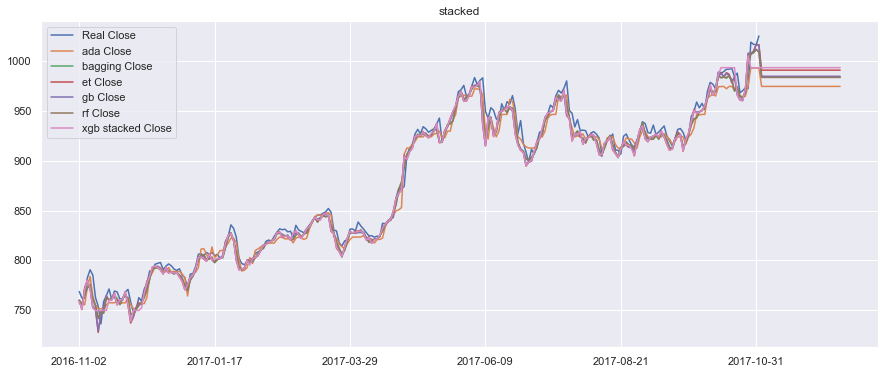

In [37]:
plt.figure(figsize = (15,6))
x_range = np.arange(df.Close.shape[0])
x_range_future = np.arange(len(xgb_list))
plt.plot(x_range, df.Close, label = 'Real Close')
plt.plot(x_range_future, reverse_close(np.array(ada_list)), label = 'ada Close')
plt.plot(x_range_future, reverse_close(np.array(bagging_list)), label = 'bagging Close')
plt.plot(x_range_future, reverse_close(np.array(et_list)), label = 'et Close')
plt.plot(x_range_future, reverse_close(np.array(gb_list)), label = 'gb Close')
plt.plot(x_range_future, reverse_close(np.array(rf_list)), label = 'rf Close')
plt.plot(x_range_future, reverse_close(np.array(xgb_list)), label = 'xgb stacked Close')
plt.legend()
plt.xticks(x_range_future[::50], pd.Series(date_ori).dt.strftime(date_format='%Y-%m-%d').tolist()[::50])
plt.title('stacked')
plt.show()

### NOTE: after some days the models converge to the mean (expected)